# Unpaired data loading
> Loading of the dataset into the fastai `DataLoaders` class.

In [1]:
#default_exp data.unpaired

In [2]:
#export
import fastcore
import inspect
from fastai.vision.all import *
from fastai.basics import *
from typing import List
from fastai.vision.gan import *
from datasets import load_dataset

In [3]:
#hide`
from nbdev.showdoc import *

## Example Dataset - Horse to Zebra conversion

Here, we are going to use the `horse2zebra` dataset provided by UC Berkeley. I have already downloaded it, You can download it at the URL https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip with the fastai `untar_data` function. Additionally, we can view the directory with `Path.ls()` (added by fastai).

In [4]:
horse2zebra = untar_data('https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip')

In [5]:
folders = horse2zebra.ls().sorted()
print(folders)

[Path('/home/tmabraham/.fastai/data/horse2zebra/testA'), Path('/home/tmabraham/.fastai/data/horse2zebra/testB'), Path('/home/tmabraham/.fastai/data/horse2zebra/trainA'), Path('/home/tmabraham/.fastai/data/horse2zebra/trainB')]


We can see that we have four directories, a train and test directory for both domains.

## Create DataLoaders object:

We can treat the image in Domain A as the input and the image in Domain B as the target. We want to be able to index the dataset for a fixed image in domain A but a random image in domain B, in order to avoid fixed pairs. 

A brief summary of how fastai Datasets works: 
> "A Datasets creates a tuple from items (typically input,target) by applying to them each list of Transform (or Pipeline) in tfms."

(from [docs](http://dev.fast.ai/data.core#Datasets))

So for transforms we will have a list of list of transforms. Each list of transforms are used to obtain, process, and return the inputs (in this case Domain A) and the targets (Domain B) as a tuple.

Let's first get our image paths:

In [6]:
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]

We can use `get_image_files` to get the image files from the directories:

In [7]:
filesA = get_image_files(trainA_path)
filesB = get_image_files(trainB_path)

In [8]:
filesA

(#1067) [Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_6873.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_6335.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_4123.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_4785.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_1798.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_691.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_2048.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_3329.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_835.jpg'),Path('/home/tmabraham/.fastai/data/horse2zebra/trainA/n02381460_993.jpg')...]

Now, we can have a Transform that randomly selects an image in domain B for the current pair:

In [9]:
#export
class RandPair(Transform):
    "Returns a random image from domain B, resulting in a random pair of images from domain A and B."
    def __init__(self,itemsB): self.itemsB = itemsB
    def encodes(self,i): return random.choice(self.itemsB)

In [10]:
show_doc(RandPair, default_cls_level=3)

<h3 id="RandPair" class="doc_header"><code>class</code> <code>RandPair</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RandPair</code>(**`itemsB`**) :: `Transform`

Returns a random image from domain B, resulting in a random pair of images from domain A and B.

In [11]:
test_ne(RandPair(filesB)(0),RandPair(filesB)(0))
test_eq(type(RandPair(filesB)(0)),type(Path('.')))

Now let's make our `Datasets` (assume no split for now). We load as a `PILImage`, convert to a `Tensor`, and resize:

In [12]:
size=128
dsets = Datasets(filesA, tfms=[[PILImage.create, ToTensor, Resize(size)], 
                               [RandPair(filesB),PILImage.create, ToTensor, Resize(size)]],splits=None)

Now  we can create a `DataLoader`. Note that fastai allows for batch-level transforms that can be performed on an accelerator like a GPU. Let's normalize the dataset:

In [13]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(mean=0.5, std=0.5)]
dls = dsets.dataloaders(bs=4, num_workers=2, after_batch=batch_tfms)

We can also show the batch:

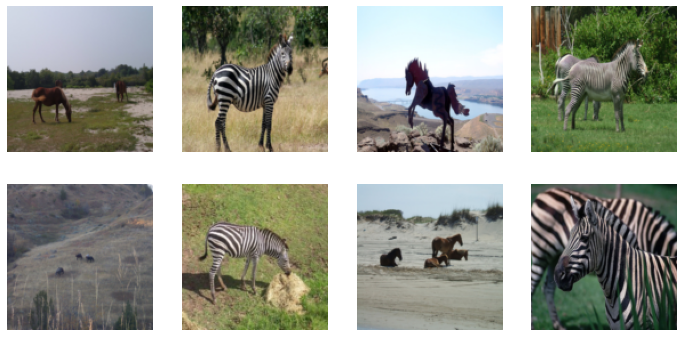

In [14]:
dls.show_batch()

In [15]:
xb,yb = dls.one_batch()
xb.shape

torch.Size([4, 3, 128, 128])

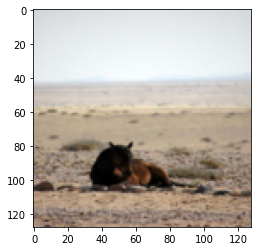

In [16]:
plt.imshow(dls.after_batch.decode(xb)[0].cpu().permute(1,2,0).numpy())

Some hacks for custom normalization for each of the inputs.

In [17]:
#export
class PILImageA(PILImage): pass
class PILImageB(PILImage): pass
class TensorImageA(TensorImage): pass
class TensorImageB(TensorImage): pass

In [18]:
#export
class ToTensorA(Transform):
    "Convert item to TensorImageA"
    order = 5
    def encodes(self, o:PILImageA): return TensorImageA(image2tensor(o))


class ToTensorB(Transform):
    "Convert item to TensorImageB"
    order = 5
    def encodes(self, o:PILImageB): return TensorImageB(image2tensor(o))

In [19]:
#export
def change_type_of_tfm(tfm, old_type, new_type):
    assert old_type in new_type.mro() # make sure it's a subclass of the old type
    NewTfm = get_class(type(tfm).__name__+'_for_'+new_type.__name__,sup=type(tfm)) # create new transform that subclasses the original
    new_tfm = NewTfm() # initialize
    new_tfm.__dict__ = tfm.__dict__.copy() # copy everything over
    new_tfm.encodes.bases = L() # bases set to empty
    new_tfm.decodes.bases = L() # bases set to empty
    t_encodes = fastcore.dispatch._TypeDict() # create a _TypeDict for the encode funcs
    new_tfm.encodes.funcs = fastcore.dispatch._TypeDict() # create a _TypeDict for the encode funcs
    new_tfm.encodes.funcs.add(new_type, t_encodes) # add the new type
    if type(tfm).encodes.funcs.d.get(old_type) is not None: t_encodes.add(object, type(tfm).encodes.funcs.d.get(old_type).d.get(object)) # add the function
    t_decodes = fastcore.dispatch._TypeDict() # create a _TypeDict for the decode funcs
    new_tfm.decodes.funcs = fastcore.dispatch._TypeDict() # create a _TypeDict for the decode funcs
    new_tfm.decodes.funcs.add(new_type, t_decodes) # add the new type
    if type(tfm).decodes.funcs.d.get(old_type) is not None: t_decodes.add(object, type(tfm).decodes.funcs.d.get(old_type).d.get(object)) # add the function
    return new_tfm

In [20]:
dummy_data = np.ones((128,128,3))

In [21]:
normalize_tfm = Normalize.from_stats(1,1)

In [22]:
test_eq(normalize_tfm(TensorImage(dummy_data).cuda())[0],TensorImage(np.zeros((128,128,3))).cuda())

In [23]:
new_normalize_tfm = change_type_of_tfm(normalize_tfm, TensorImage, TensorImageA)

In [24]:
test_eq(new_normalize_tfm(TensorImageA(dummy_data).cuda())[0],TensorImageA(np.zeros((128,128,3))).cuda())

Let's add a data loading function to our library. Note that we don't have a validation set (not necessary for CycleGAN training). Also note that we load the images with size `load_size` and take a random crop of the image with size `crop_size` (default of 256x256) to load into the model. We can also specify a subset of the data if we want (`num_A` and `num_B`). Finally, we have provided an optional argument to add your own transforms if you need.

In [25]:
#export
def get_dls(pathA, pathB, num_A=None, num_B=None, load_size=512, crop_size=256, item_tfms=None, batch_tfms=None, bs=4, num_workers=2, normalize=False):
    """
    Given image files from two domains (`pathA`, `pathB`), create `DataLoaders` object.
    Loading and randomly cropped sizes of `load_size` and `crop_size` are set to defaults of 512 and 256.
    Batch size is specified by `bs` (default=4).
    """
    filesA = get_image_files(pathA)
    filesB = get_image_files(pathB)
    filesA = filesA[:min(ifnone(num_A, len(filesA)),len(filesA))]
    filesB = filesB[:min(ifnone(num_B, len(filesB)),len(filesB))]

    if item_tfms is None: item_tfms = [Resize(load_size), RandomCrop(crop_size)]
    if type(item_tfms)==dict:
        item_tfms = [Resize(load_size), RandomCrop(crop_size)] + [change_type_of_tfm(tfm, TensorImage, TensorImageA) for tfm in L(item_tfms.get(TensorImageA,[]))] \
        + [change_type_of_tfm(tfm, TensorImage, TensorImageB) for tfm in L(item_tfms.get(TensorImageB,[]))]
    
    dsets = Datasets(filesA, tfms=[[PILImageA.create, ToTensorA, *item_tfms],
                                   [RandPair(filesB),PILImageB.create, ToTensorB, *item_tfms]], splits=None)
    
    _batch_tfms = [IntToFloatTensor]
    
    new_batch_tfms = []
    
    if batch_tfms is None:
        if normalize == True:
            x_A = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[0],0) for i in dsets]))
            meanA,stdA = x_A.mean((0,2,3), keepdim=True),x_A.std((0,2,3), keepdim=True)+1e-7
            x_B = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[1],0) for i in dsets]))
            meanB,stdB = x_B.mean((0,2,3), keepdim=True),x_B.std((0,2,3), keepdim=True)+1e-7  
            new_batch_tfms += [change_type_of_tfm(Normalize.from_stats(mean=meanA,std=stdA),TensorImage,TensorImageA), 
                               change_type_of_tfm(Normalize.from_stats(mean=meanB,std=stdB),TensorImage,TensorImageB)]
        
        else: new_batch_tfms.append(Normalize.from_stats(mean=0.5, std=0.5))
            
        new_batch_tfms.append(FlipItem(p=0.5))
        
    if type(batch_tfms)==dict:
        new_batch_tfms += [change_type_of_tfm(tfm, TensorImage, TensorImageA) for tfm in L(batch_tfms.get(TensorImageA,[]))]
        new_batch_tfms += [change_type_of_tfm(tfm, TensorImage, TensorImageB) for tfm in L(batch_tfms.get(TensorImageB,[]))]
    _batch_tfms = _batch_tfms + new_batch_tfms

    dls = dsets.dataloaders(bs=bs, num_workers=num_workers, after_batch=_batch_tfms)

    return dls

### Quick tests:

In [26]:
load_size=512
crop_size=256
bs=4
dls = get_dls(trainA_path, trainB_path,load_size=load_size,crop_size=crop_size,bs=bs)

In [27]:
test_eq(type(dls[0]),TfmdDL)
test_eq(len(dls[0]),int(len(trainA_path.ls())/bs))
test_eq(len(dls[1]),0)

In [28]:
xb,yb = next(iter(dls[0]))
test_eq(xb.shape,yb.shape)
test_eq(xb.shape,torch.Size([bs, 3, crop_size, crop_size]))

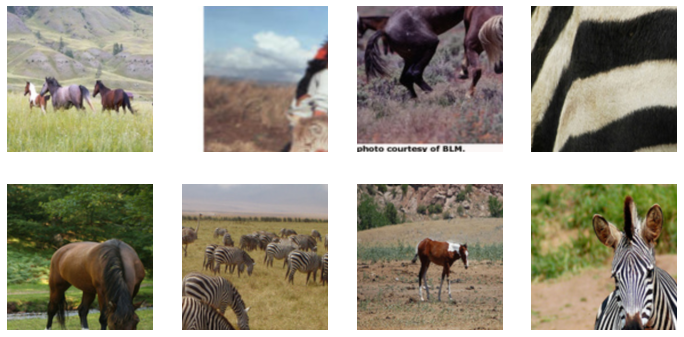

In [29]:
dls.show_batch()

In [30]:
num_A = 100
num_B = 150
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size,bs=bs)

In [31]:
test_eq(len(dls[0]),int(min(num_A,num_B)/bs))

In [32]:
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size, 
              batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(mean=0.5, std=0.5)], bs=bs)

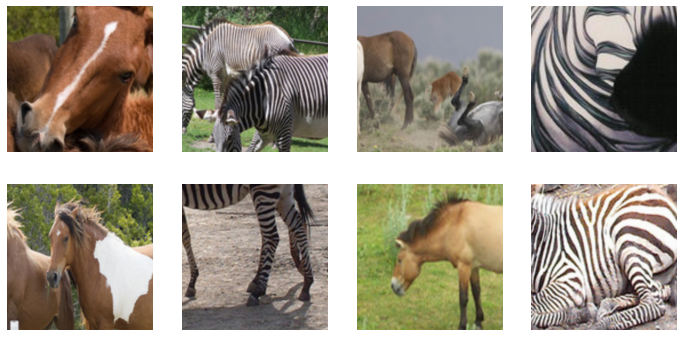

In [33]:
dls.show_batch()

In [34]:
class MakeAll(Transform):
    order=5
    def __init__(self, value): self.value = value
    def encodes(self, x:TensorImage): return TensorImage(torch.ones(*x.shape))*self.value
    def decodes(self, x:TensorImage): return x

In [35]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,item_tfms={TensorImageA: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(xb, TensorImage(torch.ones(*xb.shape)).cuda())

In [36]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,item_tfms={TensorImageB: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(yb, TensorImage(torch.ones(*yb.shape)).cuda())

In [37]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,item_tfms={TensorImageA: MakeAll(0.), TensorImageB: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(xb, TensorImage(-1*torch.ones(*xb.shape)).cuda())
test_eq(yb, TensorImage(torch.ones(*yb.shape)).cuda())

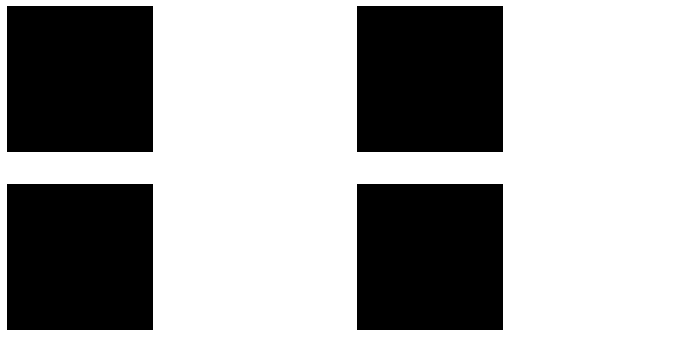

In [38]:
dls.show_batch()

In [39]:
from albumentations import RandomContrast

In [40]:
class AlbumentationsTfm(Transform):
    order=5
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: TensorImage):
        aug_img = self.aug(image=np.array(img))['image']
        return type(img)(aug_img)

In [41]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,item_tfms={TensorImageA: AlbumentationsTfm(aug=RandomContrast((0.75,0.99),p=1)), \
                                                                                           TensorImageB: AlbumentationsTfm(aug=RandomContrast((-0.75,-0.99),p=1))}, bs=bs)

/home/tmabraham/anaconda3/envs/UPIT/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


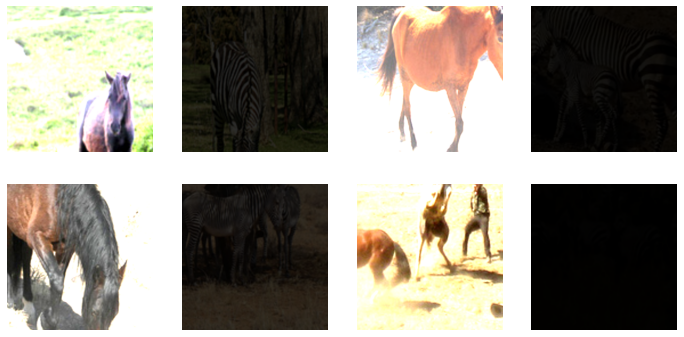

In [42]:
dls.show_batch()

In [43]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,batch_tfms={TensorImageA: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(xb, TensorImage(torch.ones(*xb.shape)))

In [44]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,batch_tfms={TensorImageB: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(yb, TensorImage(torch.ones(*yb.shape)))

In [45]:
dls = get_dls(trainA_path, trainB_path, load_size=load_size,crop_size=crop_size,batch_tfms={TensorImageA: MakeAll(0.), TensorImageB: MakeAll(255.)}, bs=bs)
xb, yb = next(iter(dls[0]))
test_eq(xb, TensorImage(torch.zeros(*xb.shape)))
test_eq(yb, TensorImage(torch.ones(*yb.shape)))

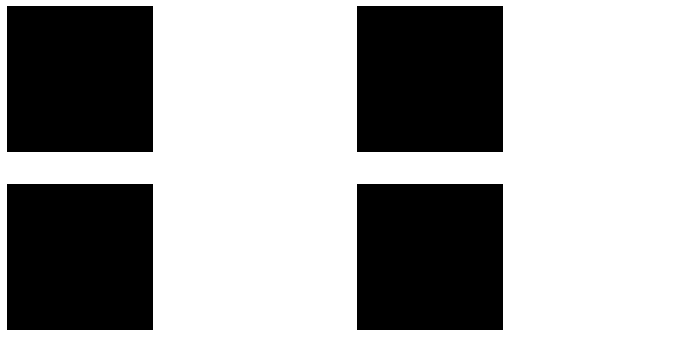

In [46]:
dls.show_batch()

In [47]:
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size, normalize=False, bs=bs)

In [48]:
dummy_dl = DataLoader(Datasets([(TensorImageA(torch.ones(3,256,256)),TensorImageB(torch.ones(3,256,256))) for i in range(100)]))
dummy_dl.to('cuda')
xb,yb=dls.after_batch(next(iter(dummy_dl)))[0]
test_eq(TensorImage(xb),TensorImage(yb))

In [49]:
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size, normalize=True, bs=bs)

In [50]:
dummy_dl = DataLoader(Datasets([(TensorImageA(torch.ones(3,256,256)),TensorImageB(torch.ones(3,256,256))) for i in range(100)]))
dummy_dl.to('cuda')
xb,yb=dls.after_batch(next(iter(dummy_dl)))[0]
test_ne(TensorImage(xb),TensorImage(yb))

## HuggingFace Datasets Loader

[HuggingFace](https://huggingface.co) has a [Datasets](https://huggingface.co/docs/datasets) package that allows us to access the hundreds of datasets available on the [Hub](https://huggingface.co/datasets). This includes our Horse-to-Zebra dataset (over [here](https://huggingface.co/datasets/huggan/horse2zebra)). Here is another helper function specific for creating dataloaders for datasets available on the HuggingFace Hub:

In [51]:
#export

def convert_func(x): return x.convert(mode='RGB')
def create_image(x, image_type): 
    if image_type == 'A': return PILImageA(x)
    if image_type == 'B': return PILImageB(x)


def get_dls_from_hf(dataset_name, fieldA='imageA', fieldB='imageB', num_A=None, num_B=None, load_size=512, crop_size=256, item_tfms=None, batch_tfms=None, bs=4, num_workers=2, normalize=False):
    """
    Given a name of a dataset available on the HuggingFace Hub, create `DataLoaders` object. 
    Field names given in `fieldA` and `fieldB` arguments.
    Loading and randomly cropped sizes of `load_size` and `crop_size` are set to defaults of 512 and 256.
    Batch size is specified by `bs` (default=4).
    """
    
    dataset = load_dataset(dataset_name)
    imagesA = dataset['train'][fieldA]
    imagesB = dataset['train'][fieldB]
    
    imagesA = imagesA[:min(ifnone(num_A, len(imagesA)),len(imagesA))]
    imagesB = imagesB[:min(ifnone(num_B, len(imagesB)),len(imagesB))]

    if item_tfms is None: item_tfms = [Resize(load_size), RandomCrop(crop_size)]
    if type(item_tfms)==dict:
        item_tfms = [Resize(load_size), RandomCrop(crop_size)] + [change_type_of_tfm(tfm, TensorImage, TensorImageA) for tfm in L(item_tfms.get(TensorImageA,[]))] \
        + [change_type_of_tfm(tfm, TensorImage, TensorImageB) for tfm in L(item_tfms.get(TensorImageB,[]))]
    
    dsets = Datasets(imagesA, tfms=[[np.asarray, Image.fromarray, convert_func, partial(create_image, image_type='A'), ToTensorA, *item_tfms], #np.asarray included as a hack to deal with JpegImageFile
                                   [RandPair(imagesB), np.asarray, Image.fromarray, convert_func, partial(create_image, image_type='B'), ToTensorB, *item_tfms]], splits=None) 

    _batch_tfms = [IntToFloatTensor]
    
    new_batch_tfms = []
    
    if batch_tfms is None:
        if normalize == True:
            x_A = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[0],0) for i in dsets]))
            meanA,stdA = x_A.mean((0,2,3), keepdim=True),x_A.std((0,2,3), keepdim=True)+1e-7
            x_B = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[1],0) for i in dsets]))
            meanB,stdB = x_B.mean((0,2,3), keepdim=True),x_B.std((0,2,3), keepdim=True)+1e-7  
            new_batch_tfms += [change_type_of_tfm(Normalize.from_stats(mean=meanA,std=stdA),TensorImage,TensorImageA), 
                               change_type_of_tfm(Normalize.from_stats(mean=meanB,std=stdB),TensorImage,TensorImageB)]
        
        else: new_batch_tfms.append(Normalize.from_stats(mean=0.5, std=0.5))
            
        new_batch_tfms.append(FlipItem(p=0.5))
        
    if type(batch_tfms)==dict:
        new_batch_tfms += [change_type_of_tfm(tfm, TensorImage, TensorImageA) for tfm in L(batch_tfms.get(TensorImageA,[]))]
        new_batch_tfms += [change_type_of_tfm(tfm, TensorImage, TensorImageB) for tfm in L(batch_tfms.get(TensorImageB,[]))]
    _batch_tfms = _batch_tfms + new_batch_tfms

    dls = dsets.dataloaders(bs=bs, num_workers=num_workers, after_batch=_batch_tfms)

    return dls

### Quick tests

In [52]:
load_size=512
crop_size=256
bs=4
dls = get_dls_from_hf('huggan/horse2zebra',load_size=load_size,crop_size=crop_size,bs=bs)

Using custom data configuration huggan--horse2zebra-aligned-424fab4179d04c8e
Reusing dataset parquet (/home/tmabraham/.cache/huggingface/datasets/parquet/huggan--horse2zebra-aligned-424fab4179d04c8e/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

In [53]:
test_eq(type(dls[0]),TfmdDL)

In [54]:
xb,yb = next(iter(dls[0]))
test_eq(xb.shape,yb.shape)
test_eq(xb.shape,torch.Size([bs, 3, crop_size, crop_size]))

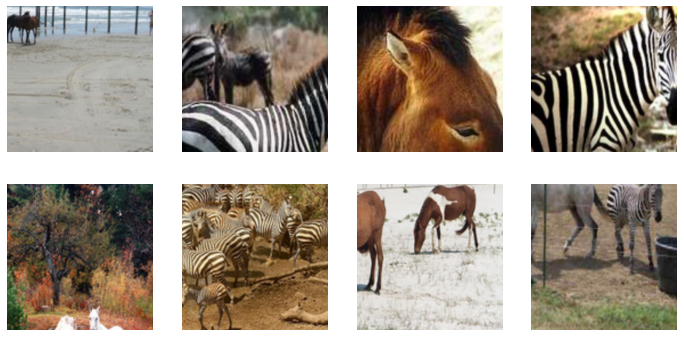

In [55]:
dls.show_batch()

In [56]:
for i in dls[0]:
    pass

In [57]:
dls = get_dls_from_hf('huggan/horse2zebra',fieldA='imageB',fieldB='imageA',load_size=load_size,crop_size=crop_size,bs=bs)

Using custom data configuration huggan--horse2zebra-aligned-424fab4179d04c8e
Reusing dataset parquet (/home/tmabraham/.cache/huggingface/datasets/parquet/huggan--horse2zebra-aligned-424fab4179d04c8e/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

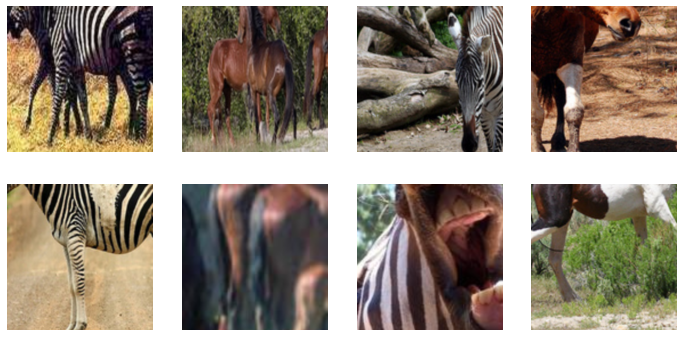

In [58]:
dls.show_batch()

In [59]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired-Copy1.ipynb.
Converted 02_data.unpaired.ipynb.
Converted 03_train.cyclegan.ipynb.
Converted 04_inference.cyclegan.ipynb.
Converted 05_metrics.ipynb.
Converted 06_tracking.wandb.ipynb.
Converted 07_models.dualgan.ipynb.
Converted 08_train.dualgan.ipynb.
Converted 09_models.ganilla.ipynb.
Converted index.ipynb.
